<a href="https://colab.research.google.com/github/neel26desai/basic_neural_networks/blob/main/neural_network_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tensorflow as tf

In [3]:
seed= 37
torch.manual_seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# defining the data
n, d = 100, 3  # 100 records 3 features

# creating x, values will be between -1 and 1 and the shape will be n,d
x = torch.rand(n, d) * 2 - 1  # Uniform distribution between -1 and 1

# creating weights that allow us to get the y_true values
weights_true = torch.tensor([[5], [3], [1]], dtype=torch.float32)
bias_true = torch.tensor([1], dtype=torch.float32)

# creating an equation for our y_true using torch.einsum for matrix multiplication
y_true = torch.einsum('ij,jk->ik', x ** 3, weights_true) + \
         torch.einsum('ij,jk->ik', x ** 2, weights_true) + \
         torch.einsum('ij,jk->ik', x, weights_true) + bias_true

print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: torch.Size([100, 3]), weights: torch.Size([3, 1]), bias: torch.Size([1]), y: torch.Size([100, 1])


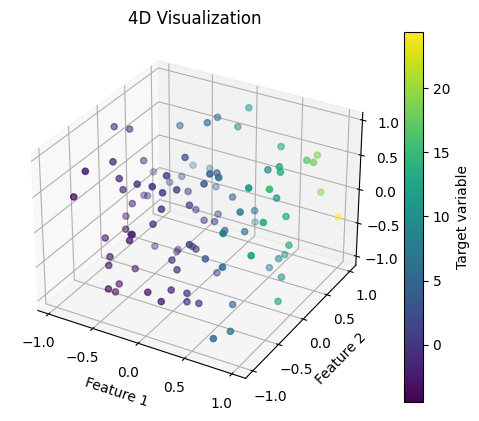

In [5]:
#defining function for visualizaing the data
def visualize_4d_data(x, y_true):
    """
    Visualizes 4D data using a 3D scatter plot with color representing the fourth dimension.

    Args:
    x (numpy.ndarray): Input features with shape (n, 3).
    y_true (numpy.ndarray): Target variable with shape (n, 1).
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_true.ravel(), cmap='viridis')
    plt.colorbar(scatter, label='Target variable')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    plt.title('4D Visualization')
    plt.show()

# Example usage
visualize_4d_data(x, y_true)

We will be leveraging Pytorch's autograd feature. PyTorch tensors can remember where they come from in terms of the operations and parent tensors that originated them, and they can provide the chain of derivatives of such operations with respect to their inputs automatically. Given a forward expression, no matter how nested, PyTorch provides the gradient of that expression with respect to its input parameters automatically.

When we set requires_grad as true for a tensor. Pytorch tracks the entire family tree of tensors resulting from operations on params. In other words any tensor that has params as an accestor has ccess to the chain of functions that were called to get from params to that tensor. In case these functions are differentiable , the value of the derivative is automatically popullated as grad attribute of the params tensor.

Calling backward leads to accumulation of derivaties at leafe node, we need to zero te gradiet explicitly after using it for parameter update.





#From Scrath - Using Pytorch's requires gradient paramater (automatic differential)

In [16]:
import torch

class LinearLayer:
    def __init__(self, input_dim, output_dim):
        self.weight = torch.randn(input_dim, output_dim, requires_grad=True) #required_grad argument tells pytorch that we need to be able to calculate gradient for these values
        self.bias = torch.randn(output_dim, requires_grad=True)
        #in pytorch backprop and gradient computations are handled automatically through a feature called automatic differential. The the required_grad feature is set to true for a tensor.

    def forward(self, x):
        # Multiply the input by the weight matrix and add the bias
        return torch.einsum('ij,jk->ik', x, self.weight) + self.bias

class ReLU:
    def forward(self, x):
        return torch.maximum(x, torch.tensor(0.0))

class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.linear1 = LinearLayer(input_dim, hidden_dim)
        self.relu1 = ReLU()
        self.linear2 = LinearLayer(hidden_dim, hidden_dim)
        self.relu2 = ReLU()
        self.linear3 = LinearLayer(hidden_dim, output_dim)

    def forward(self, x):
        x = self.linear1.forward(x)
        x = self.relu1.forward(x)
        x = self.linear2.forward(x)
        x = self.relu2.forward(x)
        x = self.linear3.forward(x)
        return x

def mse_loss(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean()

def fit(x, y, model, lr, num_epochs):
    losses = []
    for epoch in range(num_epochs):
        y_pred = model.forward(x)
        loss = mse_loss(y_pred, y)
        losses.append(loss.detach())
        loss.backward()
        with torch.no_grad():
            # as we aer upadting the weights, we dont want to keep track of these geadients
            #do these lines without keeping track of the gradient
            #this method is an alternative to the detach method, , as no_grad ensures that opertaions performed inside it's block doesn't affect the computational graph,
            #which is what you want when updating the parameters
            for layer in [model.linear1, model.linear2, model.linear3]:
                layer.weight -= lr * layer.weight.grad
                layer.bias -= lr * layer.bias.grad
                #set the gradient and biases for each layer to 0 to prepare for next iteration
                layer.weight.grad.zero_()
                layer.bias.grad.zero_()
        print(f'Epoch {epoch + 1}, loss {loss.item()}')

    return losses

# Example usage
input_dim = 3
hidden_dim = 10
output_dim = 1
lr = 0.01
num_epochs = 100

model = NeuralNetwork(input_dim, hidden_dim, output_dim)
history=fit(x, y_true, model, lr, num_epochs)


Epoch 1, loss 58.705135345458984
Epoch 2, loss 38.612247467041016
Epoch 3, loss 33.16503143310547
Epoch 4, loss 29.270648956298828
Epoch 5, loss 25.5674991607666
Epoch 6, loss 22.239465713500977
Epoch 7, loss 19.07683563232422
Epoch 8, loss 16.123767852783203
Epoch 9, loss 13.477128028869629
Epoch 10, loss 11.32730484008789
Epoch 11, loss 9.645234107971191
Epoch 12, loss 8.340740203857422
Epoch 13, loss 7.425409317016602
Epoch 14, loss 6.745675563812256
Epoch 15, loss 6.193052291870117
Epoch 16, loss 5.730167865753174
Epoch 17, loss 5.337945461273193
Epoch 18, loss 4.99237060546875
Epoch 19, loss 4.671777725219727
Epoch 20, loss 4.383427143096924
Epoch 21, loss 4.123062610626221
Epoch 22, loss 3.8955237865448
Epoch 23, loss 3.6955344676971436
Epoch 24, loss 3.5173561573028564
Epoch 25, loss 3.3548824787139893
Epoch 26, loss 3.2048566341400146
Epoch 27, loss 3.0673084259033203
Epoch 28, loss 2.941183090209961
Epoch 29, loss 2.8269777297973633
Epoch 30, loss 2.7277727127075195
Epoch 31, 

In [10]:
import numpy as np

def plot_function_and_predictions_4d(x, y_true, y_pred, output_dim=0, cmap='viridis'):
    """
    Plots the underlying function and the predicted function for a specific output dimension, with the fourth dimension represented by color.

    Args:
    x (numpy.ndarray): Input features with shape (n, 3).
    y_true (numpy.ndarray): True target values with shape (n, 2).
    y_pred (numpy.ndarray): Predicted target values with shape (n, 2).
    output_dim (int): The output dimension to visualize (0 or 1).
    cmap (str): Color map to use for the fourth dimension.
    """
    y_pred = y_pred.detach().numpy() # detach the param from current coputational graph (creating a new tensor) and convert it to numpy
    y_true = y_true.detach().numpy()
    x = x.detach().numpy()
    fig = plt.figure(figsize=(12, 6))

    # Define the color map for the fourth dimension
    norm = plt.Normalize(vmin=min(x[:, 2]), vmax=max(x[:, 2]))
    colors = plt.cm.get_cmap(cmap)(norm(x[:, 2]))

    # Plot the true values
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], y_true[:, output_dim], c=colors, marker='o', label='True')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel(f'Y{output_dim + 1}')
    ax1.set_title('Underlying Function')

    # Plot the predicted values
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], y_pred[:, output_dim], c=colors, marker='^', label='Predicted')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel(f'Y{output_dim + 1}')
    ax2.set_title('Predicted Function')

    # Add a color bar to indicate the fourth dimension
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(x[:, 2])
    plt.colorbar(mappable, ax=[ax1, ax2], label='X3 (Fourth Dimension)')

    plt.legend()
    plt.show()


<ipython-input-10-580c0a6f3f54>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(x[:, 2]))


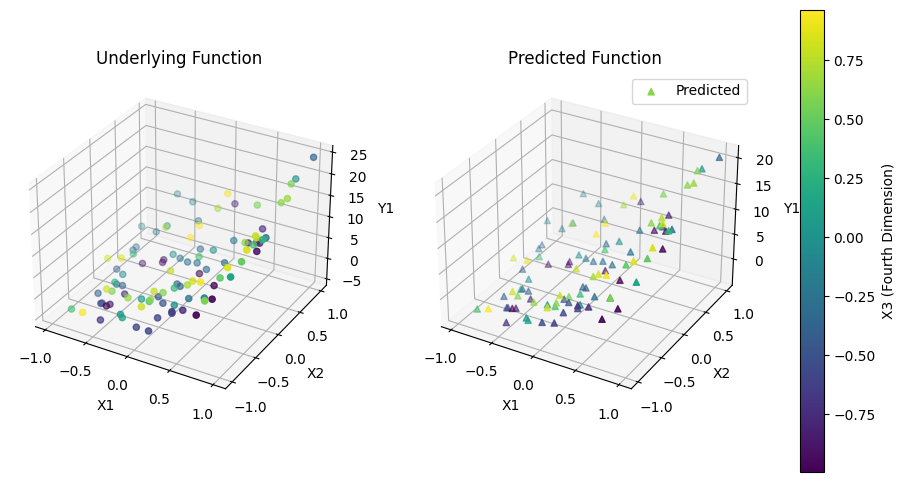

In [11]:

#plotting the difference between real distribution and predicted distribution
y_pred = model.forward(x)
plot_function_and_predictions_4d(x, y_true, y_pred, output_dim=0)

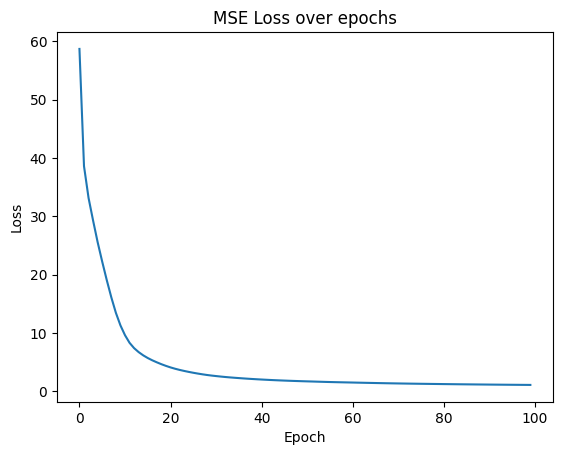

In [17]:
#plot the mse value over each epoch
plt.plot(np.asarray(history))
plt.title('MSE Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Using Pytorch's Layer Functionality

# Using Optimizer provideed in PyTorch and in heirting Module class for out  layers

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, output_dim))
        self.bias = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):
        return torch.einsum('ij,jk->ik', x, self.weight) + self.bias

    def backward(self, grad_output):
        # grad_input = grad_output @ self.weight.T
        grad_input  = torch.einsum('ij,jk->ik', grad_output, self.weight.T)
        # grad_weight = self.input.T @ grad_output
        grad_weight = torch.einsum('ij,jk->ik', self.grad_input.T, grad_output)
        grad_bias = grad_output.sum(axis=0)
        return grad_input, grad_weight, grad_bias

    def update(self, lr, grad_weight, grad_bias):
        self.weight -= lr * grad_weight
        self.bias -= lr * grad_bias


class ReLu(nn.Module):
    def forward(self, x):
        return F.relu(x)

    def backward(self, grad_output):
        return grad_output * (self.input > 0)


class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList([
            LinearLayer(input_dim, hidden_dim),
            ReLu(),
            LinearLayer(hidden_dim, hidden_dim),
            ReLu(),
            LinearLayer(hidden_dim, output_dim)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            if isinstance(layer, LinearLayer):
                grad_output, grad_weights, grad_bias = layer.backward(grad_output)
                layer.grad_weights = grad_weights
                layer.grad_bias = grad_bias
            elif isinstance(layer, ReLu):
                grad_output = layer.backward(grad_output)
        return grad_output

    def update(self, lr):
        for layer in self.layers:
            if isinstance(layer, LinearLayer):
                layer.update(lr, layer.grad_weights, layer.grad_bias)


def fit(x, y, model, loss_fn, lr, num_epochs):
    loss_history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        print(f'Epoch {epoch + 1}, loss {loss.item()}')
    return loss_history


# Example usage
input_dim = 3
hidden_dim = 10
output_dim = 1
lr = 0.01
num_epochs = 100

model = NeuralNetwork(input_dim, hidden_dim, output_dim)
loss_fn = nn.MSELoss()

loss_history = fit(x, y_true, model, loss_fn, lr, num_epochs)


Epoch 1, loss 94.48104858398438
Epoch 2, loss 47.58625030517578
Epoch 3, loss 28.659055709838867
Epoch 4, loss 10.399835586547852
Epoch 5, loss 8.730720520019531
Epoch 6, loss 7.780902862548828
Epoch 7, loss 7.10786247253418
Epoch 8, loss 6.609538555145264
Epoch 9, loss 6.22865104675293
Epoch 10, loss 5.919261932373047
Epoch 11, loss 5.621808052062988
Epoch 12, loss 5.305356502532959
Epoch 13, loss 5.029393196105957
Epoch 14, loss 4.787735462188721
Epoch 15, loss 4.579164028167725
Epoch 16, loss 4.40060567855835
Epoch 17, loss 4.2471232414245605
Epoch 18, loss 4.101744174957275
Epoch 19, loss 3.9447641372680664
Epoch 20, loss 3.8088669776916504
Epoch 21, loss 3.689427137374878
Epoch 22, loss 3.5807833671569824
Epoch 23, loss 3.4769086837768555
Epoch 24, loss 3.383695125579834
Epoch 25, loss 3.300341844558716
Epoch 26, loss 3.22332763671875
Epoch 27, loss 3.1527161598205566
Epoch 28, loss 3.0856268405914307
Epoch 29, loss 3.0196118354797363
Epoch 30, loss 2.9518942832946777
Epoch 31, lo

<ipython-input-10-580c0a6f3f54>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(x[:, 2]))


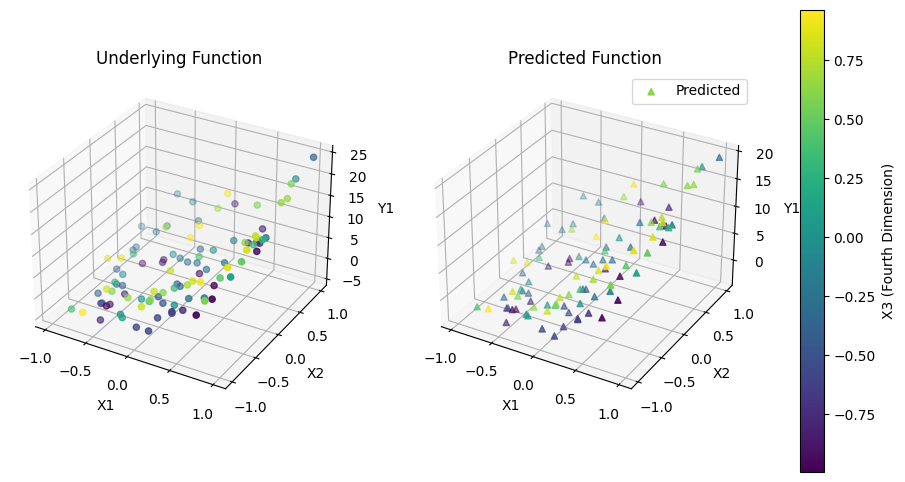

In [23]:
#plotting the difference between real distribution and predicted distribution
y_pred = model.forward(x)
plot_function_and_predictions_4d(x, y_true, y_pred, output_dim=0)

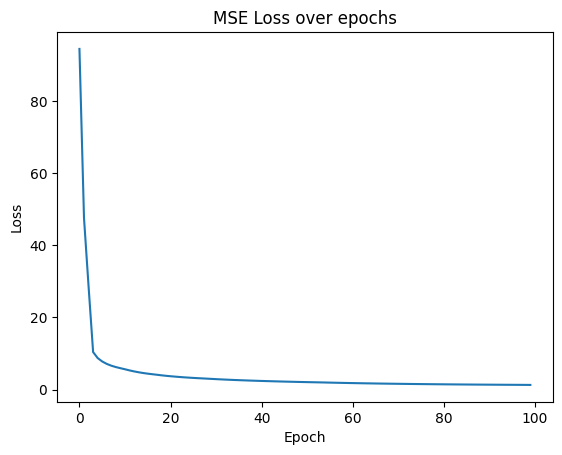

In [24]:
#plot the mse value over each epoch
plt.plot(loss_history)
plt.title('MSE Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### With train-test split

In [26]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(x, y_true)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

X_train, y_train = train_dataset[:]
X_test, y_test = test_dataset[:]

In [29]:
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
loss_fn = nn.MSELoss()

loss_history = fit(X_train, y_train, model, loss_fn, lr, num_epochs)

Epoch 1, loss 75.69318389892578
Epoch 2, loss 29.854690551757812
Epoch 3, loss 15.712862968444824
Epoch 4, loss 10.235350608825684
Epoch 5, loss 8.204713821411133
Epoch 6, loss 7.160577297210693
Epoch 7, loss 6.3490309715271
Epoch 8, loss 5.715708255767822
Epoch 9, loss 5.181492805480957
Epoch 10, loss 4.726135730743408
Epoch 11, loss 4.322793483734131
Epoch 12, loss 3.9990837574005127
Epoch 13, loss 3.7324695587158203
Epoch 14, loss 3.5066421031951904
Epoch 15, loss 3.3104043006896973
Epoch 16, loss 3.1366093158721924
Epoch 17, loss 2.9827516078948975
Epoch 18, loss 2.848733425140381
Epoch 19, loss 2.727762222290039
Epoch 20, loss 2.6207733154296875
Epoch 21, loss 2.519301652908325
Epoch 22, loss 2.424464702606201
Epoch 23, loss 2.3381259441375732
Epoch 24, loss 2.2591793537139893
Epoch 25, loss 2.186366558074951
Epoch 26, loss 2.1188783645629883
Epoch 27, loss 2.0578362941741943
Epoch 28, loss 2.0011844635009766
Epoch 29, loss 1.945349931716919
Epoch 30, loss 1.892759919166565
Epoch 

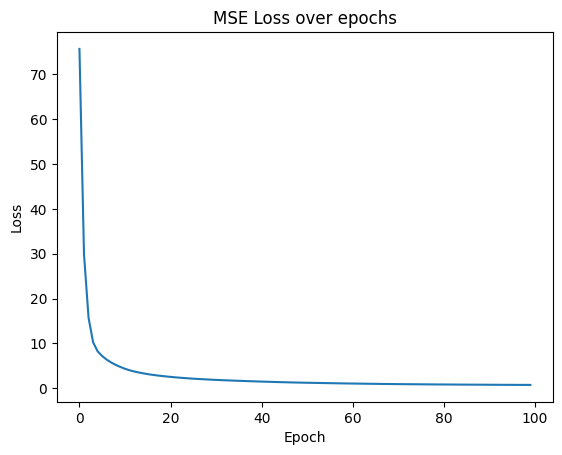

In [32]:
#plot the mse value over each epoch
plt.plot(loss_history)
plt.title('MSE Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

2.2892592


<ipython-input-10-580c0a6f3f54>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(x[:, 2]))


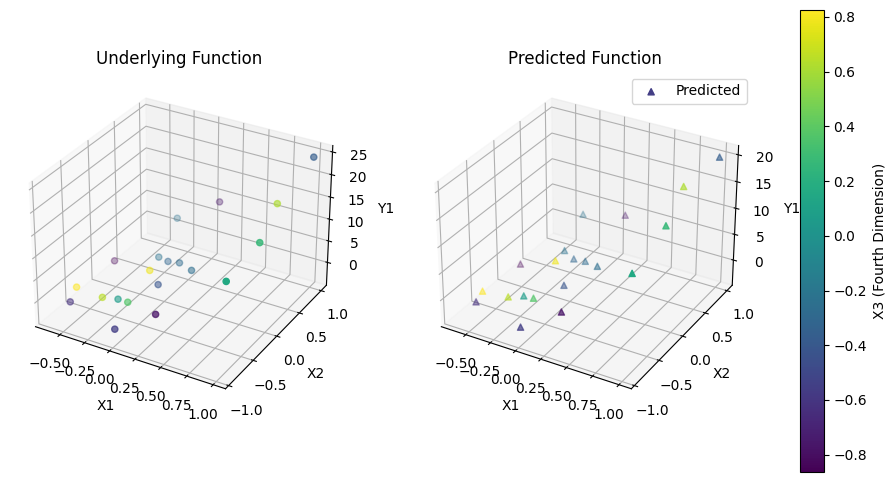

In [31]:
y_pred = model.forward(X_test)
#calculating the loss of test set
x = loss_fn(y_pred, y_test).detach().numpy()
print(x)
plot_function_and_predictions_4d(X_test, y_test, y_pred, output_dim=0)

# Using Pytorch's built in Functionalities

In [2]:
#building a classificaton dataset
import numpy as np
from sklearn.datasets import make_classification
import torch

# Generate a synthetic dataset
X, Y = make_classification(n_samples=100, n_features=3, n_informative=3, n_redundant=0, n_classes=2)

# Convert to PyTorch tensors
x = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(Y, dtype=torch.float32)

# Print the shapes of the tensors
print(f'Features tensor shape: {x.shape}')
print(f'Target tensor shape: {y.shape}')

Features tensor shape: torch.Size([100, 3])
Target tensor shape: torch.Size([100])


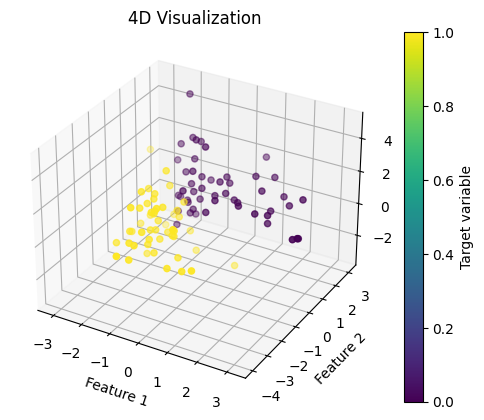

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a function to plot the 4D data
#defining function for visualizaing the data
def visualize_4d_data(x, y_true):
    """
    Visualizes 4D data using a 3D scatter plot with color representing the fourth dimension.

    Args:
    x (numpy.ndarray): Input features with shape (n, 3).
    y_true (numpy.ndarray): Target variable with shape (n, 1).
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_true.ravel(), cmap='viridis')
    plt.colorbar(scatter, label='Target variable')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    plt.title('4D Visualization')
    plt.show()

# Example usage
visualize_4d_data(x, y)

In [5]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([80, 3]), torch.Size([20, 3]), torch.Size([80]), torch.Size([20]))

In [20]:
#reshaping y to be of the form n_rows,1
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [21]:
y_train.shape, y_test.shape

(torch.Size([80, 1]), torch.Size([20, 1]))

## Using Sequential

In [7]:
import torch.nn as nn

In [15]:
#
print(model)

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)


In [30]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [49]:
#defining the model architecture
model = nn.Sequential(
    nn.Linear(3, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)

#defining the loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#defining parameter for training
n_epochs = 100
batch_size = 10

accuraries = []
#loss over epochs
losses = []

for epoch in range(n_epochs):
    temp_acc = []
    temp_loss = []
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        acc = (y_pred.round() == y_batch).float().mean()
        temp_acc.append(acc.item())
        temp_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuraries.append(sum(temp_acc)/len(temp_acc))
    losses.append(sum(temp_loss)/len(temp_loss))

print(f"After {n_epochs} epochs the loss on train set is {losses[-1]}")
print(f"After {n_epochs} epochs the accuracy on train set is {accuraries[-1]}")



After 100 epochs the loss on train set is 0.0014195913871049015
After 100 epochs the accuracy on train set is 1.0


In [51]:
#testting the performance on the test set
with torch.no_grad():
    y_pred = model(X_test)
    loss = loss_fn(y_pred, y_test)
    acc = (y_pred.round() == y_test).float().mean()
print(f"Accuracy on test set is {acc.item()}")
print(f"Loss on test set is {loss.item()}")

Accuracy on test set is 0.8500000238418579
Loss on test set is 0.35832077264785767


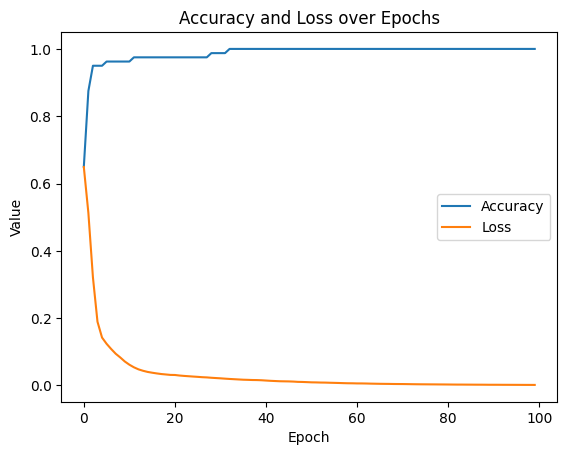

In [52]:
#plotting the accuracy an loss over epochs
plt.plot(accuraries, label='Accuracy')
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss over Epochs')
plt.legend()
plt.show()

## Without sequential layers

In [62]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer1=nn.Linear(input_dim, hidden_dim)
        self.layer2=nn.ReLU()
        self.layer3=nn.Linear(hidden_dim, hidden_dim)
        self.layer4=nn.ReLU()
        self.layer5=nn.Linear(hidden_dim, output_dim)
        self.layer6=nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x


In [63]:
model = Model(3, 10, 1)

In [64]:
print(model)

Model(
  (layer1): Linear(in_features=3, out_features=10, bias=True)
  (layer2): ReLU()
  (layer3): Linear(in_features=10, out_features=10, bias=True)
  (layer4): ReLU()
  (layer5): Linear(in_features=10, out_features=1, bias=True)
  (layer6): Sigmoid()
)


In [65]:
#defining the loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#defining parameter for training
n_epochs = 100
batch_size = 10

accuraries = []
#loss over epochs
losses = []

for epoch in range(n_epochs):
    temp_acc = []
    temp_loss = []
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        acc = (y_pred.round() == y_batch).float().mean()
        temp_acc.append(acc.item())
        temp_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuraries.append(sum(temp_acc)/len(temp_acc))
    losses.append(sum(temp_loss)/len(temp_loss))

print(f"After {n_epochs} epochs the loss on train set is {losses[-1]}")
print(f"After {n_epochs} epochs the accuracy on train set is {accuraries[-1]}")



After 100 epochs the loss on train set is 0.0036698111418900226
After 100 epochs the accuracy on train set is 1.0


In [66]:
#testting the performance on the test set
with torch.no_grad():
    y_pred = model(X_test)
    loss = loss_fn(y_pred, y_test)
    acc = (y_pred.round() == y_test).float().mean()
print(f"Accuracy on test set is {acc.item()}")
print(f"Loss on test set is {loss.item()}")

Accuracy on test set is 0.800000011920929
Loss on test set is 0.23282858729362488


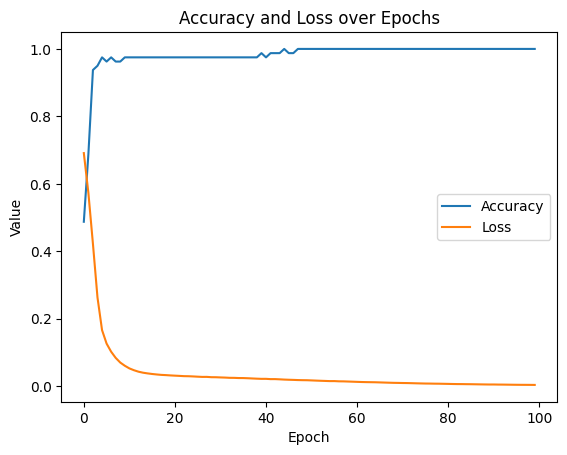

In [67]:
#plotting the accuracy an loss over epochs
plt.plot(accuraries, label='Accuracy')
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss over Epochs')
plt.legend()
plt.show()